# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\masoud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\masoud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\masoud\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.shape

(45993, 3)

In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
# FOUND : Null entries in email
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [7]:
df[df.email.isnull() == True]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [8]:
# Top 5 articles(most interacted with)
df.article_id.value_counts().sort_values(ascending = False).head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [9]:
# How many times different users have interacted with different articles
user_article = df.groupby(by=['email', 'article_id']).count()
user_article

title
email                                    article_id       
0000b6387a0366322d7fbfc6434af145adf7fed1 43.0            2
                                         124.0           1
                                         173.0           1
                                         288.0           1
                                         349.0           1
...                                                    ...
fffb93a166547448a0ff0232558118d59395fecd 981.0           1
                                         1304.0          1
                                         1305.0          8
                                         1430.0          1
                                         1437.0          1

[33669 rows x 1 columns]

In [10]:
# maximum times IDs interacted with particular articles 
user_article.sort_values(by = 'title', ascending = False).head()

,,title
email,article_id,
1588af175b283915f597fc4719cbb2c8621c4fc2,1170.0,42
363cb98a087e4a3eb6890fd1af2d418116f85ff8,1170.0,41
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,1429.0,35
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,1429.0,35
b96a4f2e92d8572034b1e9b28f9ac673765cd074,1429.0,25


In [11]:
user_article_count = df.groupby('email')['article_id'].count().sort_values(ascending=False)

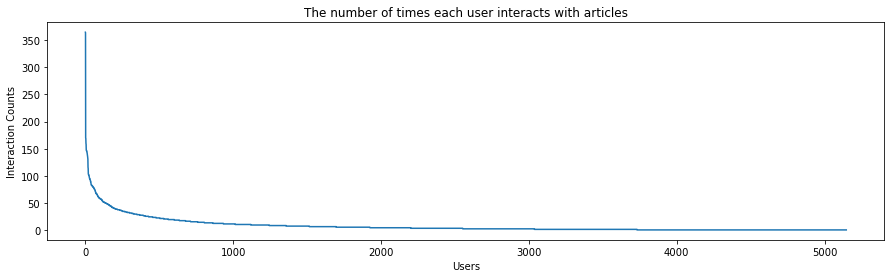

In [12]:
plt.figure(figsize=(15,4))
plt.plot(user_article_count.values)
plt.xlabel('Users')
plt.ylabel('Interaction Counts')
plt.title('The number of times each user interacts with articles')
plt.show()

Text(0, 0.5, 'Number of articles')

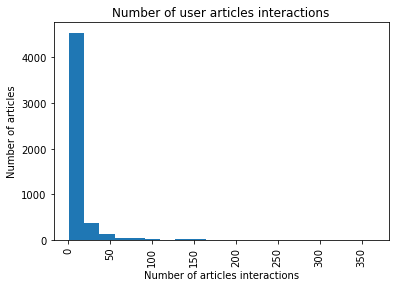

In [13]:
user_article_count.plot.hist(rot=90, bins=20)
plt.title('Number of user articles interactions')
plt.xlabel('Number of articles interactions')
plt.ylabel('Number of articles')

In [14]:
df.groupby('email')['article_id'].count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

Text(0.5, 1.0, 'Top 20 active users')

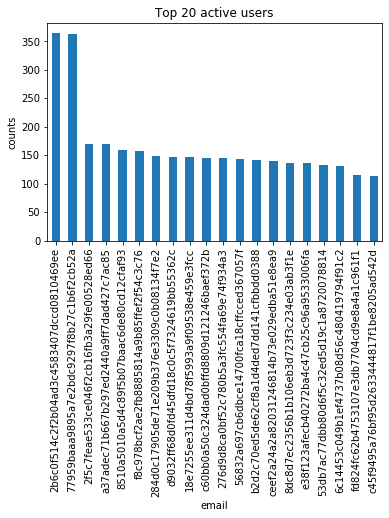

In [15]:
# Top 20 user activities
user_article_count[:20].plot(kind='bar')
plt.ylabel('counts')
plt.title('Top 20 active users')

In [16]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_article_count.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article_count.max()# The maximum number of user-article interactions by any 1 user is ______.

In [17]:
median_val, max_views_by_user

(3.0, 364)

In [18]:
user_article_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [19]:
# Find and explore duplicate articles
duplicated_articles = df_content[df_content.duplicated('article_id')]

In [20]:
duplicated_articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [21]:
# example of duplicated ID
df_content[df_content.article_id == 50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [22]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [23]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [24]:
unique_articles, total_articles, unique_users, user_article_interactions

(714, 1051, 5148, 45993)

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [25]:
most_viewed_article_id = str(df['article_id'].value_counts().index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

In [26]:
most_viewed_article_id, max_views

('1429.0', 937)

In [27]:
# No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
# map each email to a user_id

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [28]:
# If you stored all your results in the variable names above,
# you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [29]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    '''
    # Your code here
    top_ids = df['article_id'].value_counts().index[:n].tolist()
    top_articles= df[df['article_id'].isin(top_ids)]['title']
    
    # Return the top article titles from df (not df_content)
    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    '''
    # Your code here
    top_articles = df['article_id'].value_counts().sort_values(ascending=False).index[:n].astype('str').tolist()

    return top_articles  # Return the top article ids

In [30]:
print(get_top_articles(5))
print(get_top_article_ids(5))

2               use deep learning for image classification
6               use deep learning for image classification
29       predicting churn with the spss random tree alg...
37                          visualize car data with brunel
41              use deep learning for image classification
                               ...                        
45942    use xgboost, scikit-learn & ibm watson machine...
45943          insights from new york car accident reports
45957          insights from new york car accident reports
45958                       visualize car data with brunel
45960          insights from new york car accident reports
Name: title, Length: 3805, dtype: object
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [32]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_article = df.groupby(['user_id', 'article_id'])['title'].max().unstack()    
    return user_article.notnull().astype('int') # return the user_item matrix 

In [63]:
user_item = create_user_item_matrix(df)

In [65]:
# Save the user_item matrix as pickle
with open('user_item_matrix.p','wb') as f:
    pickle.dump(user_item, f)

In [34]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [35]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''
    user_vector = user_item.loc[user_id]
    
    # compute similarity of each user to the provided user
    similarity_to_user = pd.Series(user_vector.values.dot(
        user_item.transpose().values), index=user_item.index)

    # remove the own user's id
    most_similar_users = similarity_to_user.drop(user_id).sort_values(ascending=False).index.tolist()

    # return a list of the users in order from most to least similar
    return most_similar_users

In [36]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [37]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(
        article_ids)]['title'].unique().tolist()
    #article_names = df.set_index('article_id').loc[article_ids].reset_index(inplace=False)['title'].unique()    

    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist(
    )

    article_names = get_article_names(article_ids)
    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations ids for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    recs = []
    
    similar_users = find_similar_users(user_id, user_item=user_item)
    # seen movies by user
    user_seen_articles = get_user_articles(user_id, user_item=user_item)[0]

    for close_user in similar_users:
        close_user_movies = get_user_articles(close_user, user_item=user_item)[0]
        new_movies = [x for x in close_user_movies if x not in user_seen_articles]
        recs.extend(new_movies)

        if len(recs) >= m:
            break
            
    return recs[:m]  # return your recommendations for this user_id

In [38]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [39]:
get_article_names([1335.0, 555.0, 1346.0, 1444.0, 1085.0, 1151.0, 1153.0, 686.0, 1150.0, 1154.0])

['score a predictive model built with ibm spss modeler, wml & dsx',
 'airbnb data for analytics: venice listings',
 'airbnb data for analytics: venice calendar',
 'worldwide fuel oil consumption by household (in 1000 metric tons)',
 'airbnb data for analytics: vienna listings',
 'airbnb data for analytics: vienna calendar',
 'airbnb data for analytics: chicago listings',
 'military expenditure as % of gdp by country',
 'labor',
 'build a naive-bayes model with wml & dsx']

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def order(article_ids):
    '''
    sort the article ids in order of most interacted with articles to least interated with
    
    INPUT:
    article_ids- list of article ids
    
    OUTPUT:
    article_ids - (list) sorted article ids by most interacted with articles
    article_names - (list) sorted article names corresponding to above
    '''
    article_ids = [float(i) for i in article_ids]
    article_matrix = user_item.loc[:, article_ids]
    article_interactions = article_matrix.sum(axis = 0)
    article_interactions.sort_values(inplace = True)
    
    return article_interactions.index.tolist(), get_article_names(article_interactions.index.tolist())

In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe

    '''
    # Your code here
    user_vector = user_item.loc[user_id]

    # compute similarity of each user to the provided user
    similarity_to_user = pd.Series(user_vector.values.dot(
        user_item.transpose().values), index=user_item.index)

    user_interactions = df['user_id'].value_counts(
    ).sort_index().values.tolist()

    neighbors_df = pd.DataFrame({'neighbor_id': similarity_to_user.index, 'similarity': similarity_to_user.values,
                                 'num_interactions': user_interactions}).set_index('neighbor_id').drop(user_id).reset_index()

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[
                             False, False], inplace=True)
    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 

    '''
    # Your code here
    recs = []
    
    neighbor_df = get_top_sorted_users(user_id)
    # seen movies by user
    user_seen_articles, _ = get_user_articles(user_id, user_item=user_item)

    for close_user in neighbor_df['neighbor_id']:
        close_user_articles, _ = get_user_articles(close_user, user_item=user_item)
#         print(article_ids)

        new_article_ids, article_names = order(close_user_articles)
        new_articles = [x for x in new_article_ids if x not in user_seen_articles]

        recs.extend(new_article_ids)

        if len(recs) >= m:
            break
            
    recs = recs[:m]
    rec_names = get_article_names(recs)        
    return recs, rec_names

In [43]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
3931,3933,35,45
21,23,17,364
3780,3782,17,363
201,203,15,160
4457,4459,15,158
...,...,...,...
5139,5141,0,1
5142,5144,0,1
5145,5147,0,1
5146,5148,0,1


In [44]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1335.0, 555.0, 1346.0, 1444.0, 1085.0, 1151.0, 1153.0, 686.0, 1150.0, 1154.0]

The top 10 recommendations for user 20 are the following article names:
['score a predictive model built with ibm spss modeler, wml & dsx', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'worldwide fuel oil consumption by household (in 1000 metric tons)', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings', 'military expenditure as % of gdp by country', 'labor', 'build a naive-bayes model with wml & dsx']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [45]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9] # Find the 10th most similar user to user 131

In [46]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

This scenario is an example of the cold start problem were we don't have any information about the user so we can't use the collabrative based recommendation. Instead we can use knowledge based recommendations or ranked recommendations like providing the users with the most read articles so we can use the top_articles function.

**Answer: Collaborative filtering is not helpful for cold start problem. Instead, we can use techniques like rank based recommendations for new users. Which means we are gonna recommend new users with the most popular articles.**

**Given a new user, we would be able to make new recommendations using the rank based approach. But if we have to make use of the user-user approach, if the new user hasn't interacted with any articles, we won't be able to use the user-user approach as all similarities will be 0.
As we have no information regarding the new user's tastes, if we have his background information or information about him, his age, gender etc. we could use those indicators to find similar users. We could also use a knowledge based system to get his initial likings and taste and then work from there.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [47]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [48]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [52]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [58]:
def tokenize(text):
    # filter urls
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # tokenization
    tokens = word_tokenize(text)
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def make_content_recs(article_id):
    '''
    INPUT:
    article_id: one id of article.

    OUTPUT:
    recs: A list of recommended articles by content.
    '''
    # build content processing pipeline
    pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize)),
                         ('tfidf', TfidfTransformer())
                         ])
    # process doc_body and compute similarity
    X = pipeline.fit_transform(df_content['doc_body'].dropna()).toarray()
    article_row = np.dot(X, X.T)[np.where(
        df['article_id'] == article_id)[0][0]]

    # Delete article_id from row
    article_row = np.delete(article_row, np.where(
        df['article_id'] == article_id)[0][0], 0)

    # Find the 10 most similar articles
    rec_idx = (-article_row).argsort()[:10]
    recs = np.array(df_content.iloc[rec_idx, ]
                    ['article_id']).astype(float).astype(str)
    recs = [i for i in get_article_names(recs) if type(i) == str]

    return recs

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

1. clean the contents using tokenization, lemmatization.
2. process the contents into word matrices using pipeline of CountVectorizer and TfidfTransformer.
3. Dot produce the similarity and find the best 10.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [59]:
# make recommendations for a brand new user
print(get_article_names(get_top_article_ids(10)))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


In [60]:
# make a recommendations for a user who only has interacted with article id '1427.0'
print(make_content_recs(1427))

['optimizing a marketing campaign: moving from predictions to actions', "2875    hugo larochelle's neural network & deep learni...\nName: title, dtype: object", 'this week in data science (february 14, 2017)', 'using rstudio in ibm data science experience']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [66]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [67]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [68]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)

**This is different than in the lesson as here there are no null values in the matrix. FunkSVD was built so that we could work with matrices with null values as SVD doesn't converge when there are null values present in the matrix.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [71]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product / reconstruct the user_item matrix
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

In [76]:
len(sum_errs), len(num_latent_feats)

(35, 35)

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

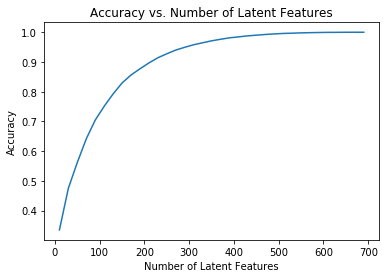

In [70]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [79]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.unique().tolist()
    test_arts = user_item_test.columns.unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

In [82]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [96]:
# How many users can we make predictions for in the test set?
unique_test_pred = set(user_item_test.index.tolist()) & set(
    user_item_train.index.tolist())
print(len(unique_test_pred))

# How many users in the test set are we not able to make predictions for because of the cold start problem?
cold_start_pred = set(user_item_test.index.tolist()) - \
    set(user_item_train.index.tolist())
print(len(cold_start_pred))

# How many articles can we make predictions for in the test set?
unique_art_prediction_can = set(user_item_test.columns.tolist()) & set(
    user_item_train.columns.tolist())
print(len(unique_art_prediction_can))

# How many articles in the test set are we not able to make predictions?
unique_art_prediction_can_not = set(
    user_item_test.columns.tolist())-set(user_item_train.columns.tolist())
print(len(unique_art_prediction_can_not))

20
662
574
0


In [97]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': len(unique_test_pred),# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': len(cold_start_pred),# letter here, 
    'How many articles can we make predictions for in the test set?': len(unique_art_prediction_can), # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':len(unique_art_prediction_can_not) # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [98]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(
    user_item_train, full_matrices=False)


row_idxs = user_item_train.index.isin(test_idx)
cols_idxs = user_item_train.columns.isin(test_arts)

u_test = u_train[row_idxs, :]
vt_test = vt_train[:, cols_idxs]

In [99]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []
user_item_test = user_item_test.loc[unique_test_pred, :]

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))    # compute error for each prediction to actual value
    
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
                    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))                  
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)              


In [109]:
user_item_test_preds.shape

(20, 574)

In [110]:
user_item_test.shape

(20, 574)

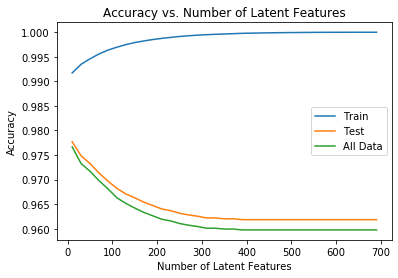

In [111]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.size), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.size), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:  
Since there were only 20 individuals who co-existed between the training and testing datasets, there isn't exactly a lot data that can be used to test how well predictions via collaborative filtering with SVD are matching up with actual values.  
Though the above plot makes it look like we are doing great in terms of accuracy, this is largely due to the class imbalance of 1's and 0's. We actually only have 3 recommendations in the test set that were actually interactions that ended up happening. This is largely the hard part with recommendations for these situations.  
As an alternative to the offline approach we used here, we could do an online approach where we run an experiment to determine the impacts of implementing one or more recommendation systems into our user base.  
A simple experiment for this situation might be to randomly assign half of users to a control group that receives no recommendations (like currently is the case). A second group randomly receives recommendations using a mix of the methods provided above. We then measure the mean/median number of interactions by users in each group. We perform a hypothesis test where the null is that there is no difference in number of interactions against an alternative that there is a difference (or that the recommendation system increases the number of user-article interactions). We use some reasonable alpha level to understand if the recommendation system increases engagement. In which case, we can move forward using the results as a basis for using the recommendation system.**

1- the training accuracy is improving with the increased number of features but for the test accuracy it starts to reduce as we add more latent features.

2- having only 20 shared user ids between the training and testing data this means we don't have enough data to test the recommendation system and this is resulting in reduced accuracy for more features.

3- since we don't have enough data yet for the current recommendation system. i would recommend using a hybrid system that ranked based recommendation engine to resolve the cold start problem and collaborative filtering or SVD for the recommendation. In order to decide whether to use SVD or collaborative filtering an A/B test experiment can be conducted to decide which works best.

**We found that the prediction accuracy on the test set decreases as the number of latent features increases but reaches a limit beyond which it doesn't go. This is because we have only 20 users whom we are trying to predict for and that's a very small response set size that doesn't actually represent how well our SVD works on the dataset. We could have interpreted our results better if we had more users whom we could predict for. But definitely the fact that our test accuracy reduces with increase in latent features is really counter-intuitive as the opposite should be happening. But this could be happening because it might be that having a lot of latent features makes the U, S and VT matrices overfit the data we have and thus it becomes difficult to predict correctly for new case. However when we have lesser latent factors, though we have lesser knowledge compared to before, we also have less bias and are less prone to overfitting and thus, will tend to make better predictions.**

**To find whether our recommendations make sense and help users find relevant articles, we must go for online testing and recommend articles on the basis of our recommendation models and see whether more users are clicking on the recommended articles or not. We could use an A/B test here and randomly select our control and treatment groups. Then we could recommend articles through one of our models in the treatment group and leave the control group as it is. By noting the number of articles interacted with in our treatment group vs the no. of articles interacted with in our control group, we could decide whether to go with our recommendation model or not.**

In [113]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(
    user_item_train, full_matrices=False)

# test parts
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
user_item_test_sub = user_item_test[user_item_test.index.isin(
    unique_test_pred)]

In [115]:
u_train.shape, s_train.shape, vt_train.shape, u_test.shape, vt_test.shape, user_item_test_sub.shape

((4487, 714), (714,), (714, 714), (20, 714), (714, 574), (20, 574))

In [116]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data
features = np.arange(10, 701, 10)
train_accuracy = []
test_accuracy = []
train_precision = []
test_precision = []
train_recall = []
test_recall = []
train_f1 = []
test_f1 = []

for i in features:

    # select latent features
    u_train_sub = u_train[:, :i]
    s_train_sub = np.diag(s_train[:i])
    vt_train_sub = vt_train[:i, :]
    u_test_sub = u_test[:, :i]
    vt_test_sub = vt_test[:i, :]

    # prediction
    user_item_train_pred = np.clip(np.around(
        np.dot(np.dot(u_train_sub, s_train_sub), vt_train_sub)), 0, 1)
    user_item_test_pred = np.clip(np.around(
        np.dot(np.dot(u_test_sub, s_train_sub), vt_test_sub)), 0, 1)

    # accuracy
    train_accuracy.append(accuracy_score(
        np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    test_accuracy.append(accuracy_score(
        np.array(user_item_test_sub).reshape(-1,), user_item_test_pred.reshape(-1,)))

    # precision
    train_precision.append(precision_score(
        np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    test_precision.append(accuracy_score(np.array(
        user_item_test_sub).reshape(-1,), user_item_test_pred.reshape(-1,)))

    # recall
    train_recall.append(recall_score(
        np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    test_recall.append(accuracy_score(np.array(
        user_item_test_sub).reshape(-1,), user_item_test_pred.reshape(-1,)))

    # f1_score
    train_f1.append(f1_score(
        np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    test_f1.append(f1_score(np.array(
        user_item_test_sub).reshape(-1,), user_item_test_pred.reshape(-1,)))

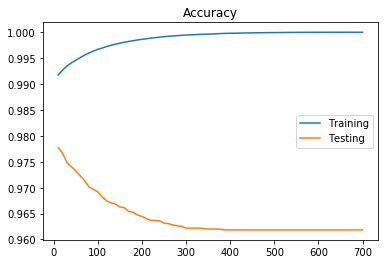

In [117]:
# Accuracy curves
plt.plot(features, train_accuracy, label='Training')
plt.plot(features, test_accuracy, label='Testing')
plt.legend()
plt.title('Accuracy')
plt.show()

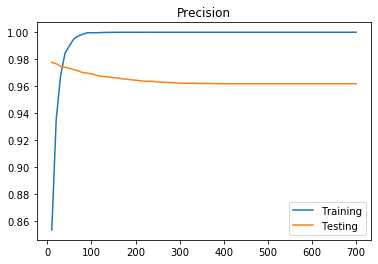

In [119]:
# Precision curves
plt.plot(features, train_precision, label='Training')
plt.plot(features, test_precision, label='Testing')
plt.legend()
plt.title('Precision')
plt.show()

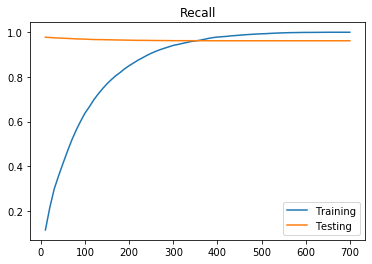

In [120]:
# Recall curves
plt.plot(features, train_recall, label='Training')
plt.plot(features, test_recall, label='Testing')
plt.legend()
plt.title('Recall')
plt.show()

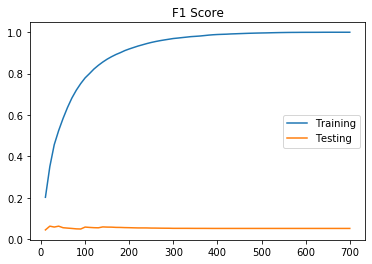

In [121]:
# F1 Score curves
plt.plot(features, train_f1, label='Training')
plt.plot(features, test_f1, label='Testing')
plt.legend()
plt.title('F1 Score')
plt.show()

We notice the dataset is unbalanced, with far more 0 than 1, which is proved by low Recall of training set because False Negative is more than True Positive. By prediction 1 as 0, accuracy is pretty good guaranteed by large 0s, but f1-score leveraged the influence and show test prediction is not very good, and the difference between training and testing shows high overfitting.

The better way to measure recommendation is trying to know whether they like the articles more. If we still use interaction to evaluate, the interaction should increase if recommendation is good. Besides, we can use the extent they like the recommendation, like rating score. If they like recommendation, their rating to those articles should be higher. Thus, we can build A/B testing to compare whether recommendation improves rating or interaction.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

In [122]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0